<a href="https://colab.research.google.com/github/ajitkumarkp/ML/blob/master/DoppelGanger_Find_Celebrity_Look_Alike.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
%cd /content/drive/My Drive/Colab Notebooks/prj2-DoppelGanger

/content/drive/My Drive/Colab Notebooks/prj2-DoppelGanger


# <font color="blue">Project: DoppelGanger Find your Celebrity Look-Alike </font>
Face Recognition algorithms work by convertin a face into a high dimensional vector and then learn a feature space in that high dimension. Once the algorithm learns a robust feature space, you can add more people to the same space and they will form a different cluster.

The project in this notebook uses the Face Embeddings to **find a doppelganger or look-alike to a given person.** Given images of people and a celebrity dataset, the task is to find the celebrity look-alike. 

## <font color="blue">The Dataset</font>
Note, there are many datasets which contain images of celebrities:
* [CelebA Dataset](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html)
* [VGGFace](https://www.robots.ox.ac.uk/~vgg/data/vgg_face/)
* [VGGFace2](http://www.robots.ox.ac.uk/~vgg/data/vgg_face2/)
* [MS-Celeb-1M](https://www.microsoft.com/en-us/research/project/ms-celeb-1m-challenge-recognizing-one-million-celebrities-real-world/)
* [Celebrity-Together Dataset](https://www.robots.ox.ac.uk/~vgg/data/celebrity_together/)

### <font color="green">celeb_mini Dataset</font>
Since most of the datasets are huge in size, a small dataset is curated for this experiment which is a subset of the Query set of the Celebrity Together Dataset. The query dataset has around 1100 celebs and is ~400MB in size. 

The subset has 5 images per celebrity. It is ~70MB in size. **`celeb_mapping.npy`** file has the mapping of the code name to the actual name of the celebrity.

The **`celeb_mini`** folder has the following structure:

```
celeb_mini
└───n00000001
│   └──n00000001_00000263.JPEG
│   └──n00000001_00000405.JPEG
│      ...
└───n00000003
│   └──n00000003_00000386.JPEG
│   └──n00000003_00000488.JPEG
│       ...
│
```
    
**`celeb_mapping.npy`** contains a dictionary which contains the mapping between the folder names and the celebrity's actual name as show below:
```
{'n00000001': 'A.J. Buckley',
 'n00000002': 'A.R. Rahman',
 'n00000003': 'Aamir Khan',
 'n00000004': 'Aaron Staton',
 'n00000005': 'Aaron Tveit',
 'n00000006': 'Aaron Yoo',
 'n00000007': 'Abbie Cornish',
 .
 .
 .
}
```


In [ ]:
import _pickle as cPickle
import os,random,glob
import dlib
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time
%matplotlib inline

In [ ]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (6.0,6.0)
matplotlib.rcParams['image.cmap'] = 'gray'
matplotlib.rcParams['image.interpolation'] = 'bilinear'

## <font color="blue">Load the model for face landmarks and face recognition</font>

Initialize Dlib’s Face Detector, Facial Landmark Detector and Face Recognition neural network objects


In [ ]:
# Download dlib models
# Landmark model
!wget https://github.com/davisking/dlib-models/raw/master/shape_predictor_68_face_landmarks.dat.bz2 -O shape_predictor_68_face_landmarks.dat.bz2
!bzip2 -d shape_predictor_68_face_landmarks.dat.bz2
# Face recognition model
!wget https://github.com/davisking/dlib-models/raw/master/dlib_face_recognition_resnet_model_v1.dat.bz2 -O dlib_face_recognition_resnet_model_v1.dat.bz2
!bzip2 -d dlib_face_recognition_resnet_model_v1.dat.bz2

In [ ]:
# Initialize face detector, facial landmarks detector 
# and face recognizer
faceDetector = dlib.get_frontal_face_detector()
shapePredictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')
faceRecognizer = dlib.face_recognition_model_v1('dlib_face_recognition_resnet_model_v1.dat')

## <font color="blue">Explore Data </font>


In [ ]:
!wget https://www.dropbox.com/s/lulw2jwsblz687g/celeb_mini.zip?dl=1 -O celeb_mini.zip
!unzip celeb_mini.zip

!wget https://www.dropbox.com/s/m7kjjoa1z1hsxw6/celeb_mapping.npy?dl=1 -O celeb_mapping.npy

!wget https://www.dropbox.com/s/3yi89blp4lhiw6y/test-images.zip?dl=1 -O test-images.zip
!unzip test-images.zip

In [ ]:
# Root folder of the dataset
faceDatasetFolder = 'celeb_mini'
# Label -> Name Mapping file
labelMap = np.load("celeb_mapping.npy", allow_pickle=True).item()

In [ ]:
print (labelMap)

In [ ]:
# Each subfolder has images of a particular celeb
subfolders = os.listdir(faceDatasetFolder)

# Let us choose a random folder and display all images
random_folder = random.choice(subfolders)

# Also find out the name of the celeb from the folder name and folder-> name mapping dictionary loaded earlier
celebname = labelMap[random_folder]

# Load all images in the subfolder
imagefiles = os.listdir(os.path.join(faceDatasetFolder, random_folder))

# Read each image and display along with the filename and celeb name
for file in imagefiles:
#     Get full path of each image file
    fullPath = os.path.join(faceDatasetFolder,random_folder,file)
    im = cv2.imread(fullPath)
    plt.imshow(im[:,:,::-1])
    plt.show()
#     Also print the filename and celeb name
    print("File path = {}".format(fullPath))
    print("Celeb Name: {}".format(celebname))


Below is the code for enrollment and testing to get the desired output 

## <font color="red">1. Enrollment of Celeb Images </font>
Process images one by and one. 

Convert image from BGR to RGB, because Dlib uses RGB as default format.

Detect faces in the image and compute a face descriptor for each image and save them in an array so that it can be used during testing.

In [ ]:
# read subfolders in folder "celeb_mini"
subfolders = []
for x in os.listdir(faceDatasetFolder):
  xpath = os.path.join(faceDatasetFolder, x)
  if os.path.isdir(xpath):
    subfolders.append(xpath)

# nameLabelMap is dict with keys as person's name
# and values as integer label assigned to this person
# labels contain integer labels for corresponding image in imagePaths
nameLabelMap = {}
labels = []
imagePaths = []
for i, subfolder in enumerate(subfolders):
  for x in os.listdir(subfolder):
    xpath = os.path.join(subfolder, x)
    if x.endswith('JPEG'):
      imagePaths.append(xpath)
      labels.append(i)
      nameLabelMap[xpath] = subfolder.split('/')[-1]

In [ ]:
print (subfolders)
print (nameLabelMap)
# imagePaths

In [ ]:
# Process images one by one
# We will store face descriptors in an ndarray (faceDescriptors)
# and their corresponding labels in dictionary (index)
index = {}
i = 0
faceDescriptors = None
for imagePath in imagePaths:
  print("processing: {}".format(imagePath))
  # read image and convert it to RGB
  img = cv2.imread(imagePath)

  # detect faces in image
  faces = faceDetector(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

  print("{} Face(s) found".format(len(faces)))
  # Now process each face we found
  for k, face in enumerate(faces):

    # Find facial landmarks for each detected face
    shape = shapePredictor(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), face)

    # convert landmarks from Dlib's format to list of (x, y) points
    # landmarks = [(p.x, p.y) for p in shape.parts()]

    # Compute face descriptor using neural network defined in Dlib.
    # It is a 128D vector that describes the face in img identified by shape.
    faceDescriptor = faceRecognizer.compute_face_descriptor(img, shape)

    # Convert face descriptor from Dlib's format to list, then a NumPy array
    faceDescriptorList = [x for x in faceDescriptor]
    faceDescriptorNdarray = np.asarray(faceDescriptorList, dtype=np.float64)
    faceDescriptorNdarray = faceDescriptorNdarray[np.newaxis, :]

    # Stack face descriptors (1x128) for each face in images, as rows
    if faceDescriptors is None:
      faceDescriptors = faceDescriptorNdarray
    else:
      faceDescriptors = np.concatenate((faceDescriptors, faceDescriptorNdarray), axis=0)

    # save the label for this face in index. We will use it later to identify
    # person name corresponding to face descriptors stored in NumPy Array
    index[i] = nameLabelMap[imagePath]
    i += 1

In [ ]:
# Write descriors and index to disk
np.save('descriptors.npy', faceDescriptors)
# index has image paths in same order as descriptors in faceDescriptors
with open('index.pkl', 'wb') as f:
  cPickle.dump(index, f)

In [ ]:
%pwd

'/content/drive/My Drive/Colab Notebooks/prj2-DoppelGanger'

In [ ]:
# load descriptors and index file generated during enrollment
index = np.load('index.pkl', allow_pickle=True)
faceDescriptorsEnrolled = np.load('descriptors.npy')

In [ ]:
print (index)

In [ ]:
len(faceDescriptorsEnrolled)

5697

## <font color="red">2. Testing</font>
Once the celebs are enrolled, use them to find the closest celeb to the given test image using minimum distance rule.

The embeddings of the test images are compared with the enrolled celebs to find the look-alike. 

Finally, display the celeb along side the input image.

In [ ]:
matplotlib.rcParams['figure.figsize'] = (12.0,12.0)

1 Face(s) found
minDistance: 0.42035198820065833
argmin: 1916


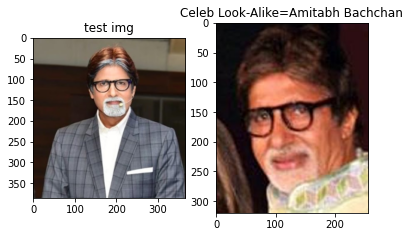

1 Face(s) found
minDistance: 0.5432982570143512
argmin: 2067


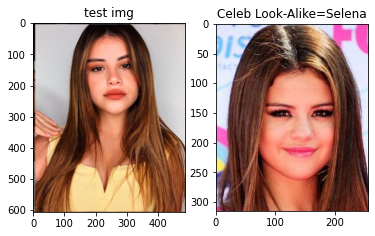

1 Face(s) found
minDistance: 0.36375677157005565
argmin: 519


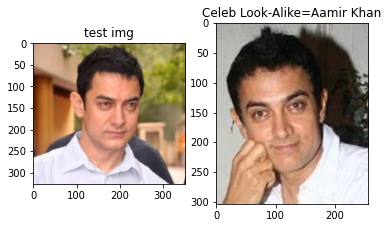

1 Face(s) found
minDistance: 0.5887784222218828
argmin: 2751


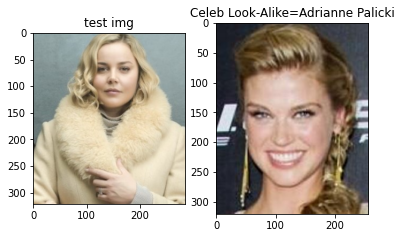

In [ ]:
# read image
testImages = glob.glob('test-images/*.jpg')

for test in testImages:
    img = cv2.imread(test)
    imDlib = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    #####################
    #  YOUR CODE HERE
    # detect faces in image
   
    # detect faces in image
    faces = faceDetector(imDlib)
    print("{} Face(s) found".format(len(faces)))

    # Now process each face we found
    for k, face in enumerate(faces):
      # Find facial landmarks for each detected face
      shape = shapePredictor(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), face)

      # convert landmarks from Dlib's format to list of (x, y) points
      # landmarks = [(p.x, p.y) for p in shape.parts()]

      # Compute face descriptor using neural network defined in Dlib.
      # It is a 128D vector that describes the face in img identified by shape.
      faceDescriptor = faceRecognizer.compute_face_descriptor(img, shape)

      # Convert face descriptor from Dlib's format to list, then a NumPy array
      faceDescriptorList = [x for x in faceDescriptor]
      faceDescriptorNdarray = np.asarray(faceDescriptorList, dtype=np.float64)
      faceDescriptorNdarray = faceDescriptorNdarray[np.newaxis, :]

      # Calculate Euclidean distances between face descriptor calculated on face dectected
      # in current frame with all the face descriptors we calculated while enrolling faces
      distances = np.linalg.norm(faceDescriptorsEnrolled - faceDescriptorNdarray, axis=1)

      # Calculate minimum distance and index of this face
      argmin = np.argmin(distances)  # index
      minDistance = distances[argmin]  # minimum distance
      # print("minDistance:", minDistance) 
      # print("argmin:", argmin) 

      # Dlib specifies that in general, if two face descriptor vectors have a Euclidean
      # distance between them less than 0.6 then they are from the same
      # person, otherwise they are from different people.

      # This threshold will vary depending upon number of images enrolled
      # and various variations (illuminaton, camera quality) between
      # enrolled images and query image
      # We are using a threshold of 0.5
      THRESHOLD = 0.6
      # If minimum distance if less than threshold
      # find the name of person from index
      # else the person in query image is unknown
      if minDistance <= THRESHOLD:
        label = index[argmin]
      else:
        label = 'unknown'

    celeb_name = labelMap[label]
    ####################
    
    plt.subplot(121)
    plt.imshow(imDlib)
    plt.title("test img")
    
    #TODO - display celeb image which looks like the test image instead of the black image. 
    imgdir = os.path.join(faceDatasetFolder,label)
    imgname = os.listdir(imgdir)[0]
    imgpath = os.path.join(faceDatasetFolder,label,imgname)
    im = cv2.imread(imgpath)
    plt.subplot(122)
    plt.imshow(im[:,:,::-1])
    plt.title("Celeb Look-Alike={}".format(celeb_name))
    plt.show()